In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from pmdarima.arima import auto_arima

In [51]:
csv_fts = "datasets/FTS Historical Data.csv"
csv_mwg = "datasets/MWG Historical Data.csv"
csv_vic = "datasets/VIC Historical Data.csv"

df_fts = pd.read_csv(csv_fts, thousands=',')
df_mwg = pd.read_csv(csv_mwg, thousands=',')
df_vic = pd.read_csv(csv_vic, thousands=',')

### Dataset 1: FTS

In [52]:
df_fts['Date'] = pd.to_datetime(df_fts['Date'])
df_fts = df_fts.sort_values(by='Date', ascending=True)
df_fts.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,5788.4,5859.2,5859.2,5788.4,103.55K,-1.21%
1358,2018-01-03,5953.7,5764.7,5977.4,5741.1,245.02K,2.86%
1357,2018-01-04,6024.6,5953.7,6142.8,5906.5,167.80K,1.19%
1356,2018-01-05,5882.9,5977.4,6048.2,5882.9,113.88K,-2.35%
1355,2018-01-08,6001.0,5859.2,6001.0,5764.7,63.36K,2.01%


In [53]:
df = df_fts
df = df[['Price']]
df = df.dropna() 
df = df.reset_index(drop=True) 

train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [54]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic


 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=14587.691, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=14448.583, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=14195.335, Time=0.18 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 3.087 seconds


ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [55]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

- Predict 30 days:

In [56]:
number_of_days_to_predict = 30

x_next_N_days = np.array(val_data.index[-number_of_days_to_predict:]).reshape(-1, 1)

y_next_N_days = model.predict(n_periods=len(x_next_N_days))

print('Predicted prices for the last 30 days:')
print(y_next_30_days)

Predicted prices for the last 30 days:
[41466.36825002 41628.33650003 41790.30475005 41952.27300006
 42114.24125008 42276.20950009 42438.17775011 42600.14600012
 42762.11425014 42924.08250016 43086.05075017 43248.01900019
 43409.9872502  43571.95550022 43733.92375023 43895.89200025
 44057.86025027 44219.82850028 44381.7967503  44543.76500031
 44705.73325033 44867.70150034 45029.66975036 45191.63800037
 45353.60625039 45515.57450041 45677.54275042 45839.51100044
 46001.47925045 46163.44750047]


In [57]:
data_last_ndays = df['Price'].values[-number_of_days_to_predict:]

# RMSE
test_rmse = mean_squared_error(y_pred, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(y_next_30_days, data_last_ndays, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(y_next_N_days, data_last_ndays)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(y_next_N_days, data_last_ndays)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))

Testing RMSE: 36983.0123
Validating RMSE: 31584.9209
Predicting 30 days RMSE: 15998.6801

Testing MAPE: 0.4552
Validating RMSE: 31584.9209
Predicting 30 days MAPE: 0.3649

Testing MSLE: 0.693
Validating RMSE: 31584.9209
Predicting 30 days MSLE: 0.2084


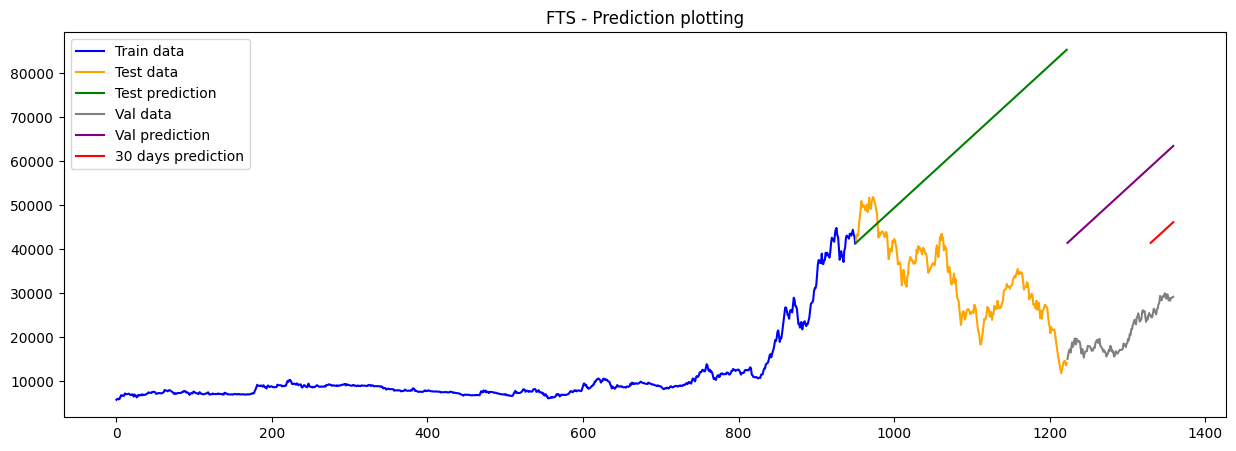

In [58]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data, c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, test_data, 'orange')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, val_data, 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df)-number_of_days_to_predict, stop=len(df), step=1)
plt.plot(prediect_data_index, y_next_N_days, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('FTS - Prediction plotting')
plt.show()

### Dataset 2: MWG

In [59]:
df_mwg['Date'] = pd.to_datetime(df_mwg['Date'])
df_mwg = df_mwg.sort_values(by='Date', ascending=True)
df_mwg.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,31276,31039,31394,31039,2.27M,0.76%
1358,2018-01-03,31892,31323,32034,31276,4.53M,1.97%
1357,2018-01-04,31963,31773,32081,31750,2.71M,0.22%
1356,2018-01-05,31608,31987,31987,31465,2.93M,-1.11%
1355,2018-01-08,31110,31394,31513,31039,3.01M,-1.58%


In [60]:
df = df_mwg
df = df[['Price']]
df = df.dropna() 
df = df.reset_index(drop=True) 

train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [61]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15238.253, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15243.039, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15244.694, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15244.728, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15243.089, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15245.229, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15245.253, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15244.929, Time=1.07 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=15244.331, Time=1.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15244.746, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15246.258, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15246.060, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=15245.162, Time=1.79 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=15237.622, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=15245.020, Time=0.13

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [62]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

- Predict 30 days:

In [63]:
number_of_days_to_predict = 30

x_next_N_days = np.array(val_data.index[-number_of_days_to_predict:]).reshape(-1, 1)

y_next_N_days = model.predict(n_periods=len(x_next_N_days))

print('Predicted prices for the last 30 days:')
print(y_next_30_days)

Predicted prices for the last 30 days:
[41466.36825002 41628.33650003 41790.30475005 41952.27300006
 42114.24125008 42276.20950009 42438.17775011 42600.14600012
 42762.11425014 42924.08250016 43086.05075017 43248.01900019
 43409.9872502  43571.95550022 43733.92375023 43895.89200025
 44057.86025027 44219.82850028 44381.7967503  44543.76500031
 44705.73325033 44867.70150034 45029.66975036 45191.63800037
 45353.60625039 45515.57450041 45677.54275042 45839.51100044
 46001.47925045 46163.44750047]


In [64]:
data_last_ndays = df['Price'].values[-number_of_days_to_predict:]

# RMSE
test_rmse = mean_squared_error(y_pred, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(y_next_30_days, data_last_ndays, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(y_next_N_days, data_last_ndays)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(y_next_N_days, data_last_ndays)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))

Testing RMSE: 8316.2252
Validating RMSE: 22440.7803
Predicting 30 days RMSE: 4217.3644

Testing MAPE: 0.0968
Validating RMSE: 22440.7803
Predicting 30 days MAPE: 0.3786

Testing MSLE: 0.0197
Validating RMSE: 22440.7803
Predicting 30 days MSLE: 0.2288


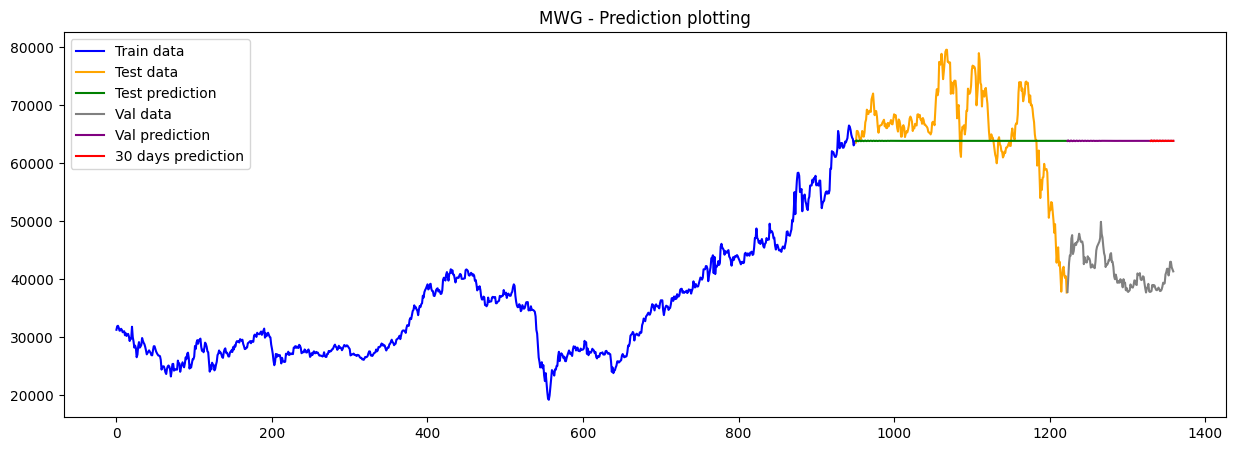

In [65]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data, c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, test_data, 'orange')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, val_data, 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df)-number_of_days_to_predict, stop=len(df), step=1)
plt.plot(prediect_data_index, y_next_N_days, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('MWG - Prediction plotting')
plt.show()

### Dataset 3: VIC

In [66]:
df_vic['Date'] = pd.to_datetime(df_vic['Date'])
df_vic = df_vic.sort_values(by='Date', ascending=True)
df_vic.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,64628,64132,64876,63967,1.74M,1.16%
1358,2018-01-03,66529,65702,68760,64959,6.07M,2.94%
1357,2018-01-04,66942,67355,68678,66529,3.55M,0.62%
1356,2018-01-05,66116,66942,66942,65289,3.42M,-1.23%
1355,2018-01-08,66364,66116,67686,65372,4.81M,0.38%


In [67]:
df = df_vic
df = df[['Price']]
df = df.dropna() 
df = df.reset_index(drop=True) 

train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [68]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16956.093, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16954.929, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16955.665, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16955.690, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16953.171, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16957.653, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.591 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [69]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

- Predict 30 days:

In [70]:
number_of_days_to_predict = 30

x_next_N_days = np.array(val_data.index[-number_of_days_to_predict:]).reshape(-1, 1)

y_next_N_days = model.predict(n_periods=len(x_next_N_days))

print('Predicted prices for the last 30 days:')
print(y_next_30_days)

Predicted prices for the last 30 days:
[41466.36825002 41628.33650003 41790.30475005 41952.27300006
 42114.24125008 42276.20950009 42438.17775011 42600.14600012
 42762.11425014 42924.08250016 43086.05075017 43248.01900019
 43409.9872502  43571.95550022 43733.92375023 43895.89200025
 44057.86025027 44219.82850028 44381.7967503  44543.76500031
 44705.73325033 44867.70150034 45029.66975036 45191.63800037
 45353.60625039 45515.57450041 45677.54275042 45839.51100044
 46001.47925045 46163.44750047]


In [71]:
data_last_ndays = df['Price'].values[-number_of_days_to_predict:]

# RMSE
test_rmse = mean_squared_error(y_pred, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(y_next_30_days, data_last_ndays, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(y_next_N_days, data_last_ndays)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(y_next_N_days, data_last_ndays)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))

Testing RMSE: 20434.7068
Validating RMSE: 37308.7972
Predicting 30 days RMSE: 8750.1833

Testing MAPE: 0.1901
Validating RMSE: 37308.7972
Predicting 30 days MAPE: 0.4301

Testing MSLE: 0.0704
Validating RMSE: 37308.7972
Predicting 30 days MSLE: 0.3167


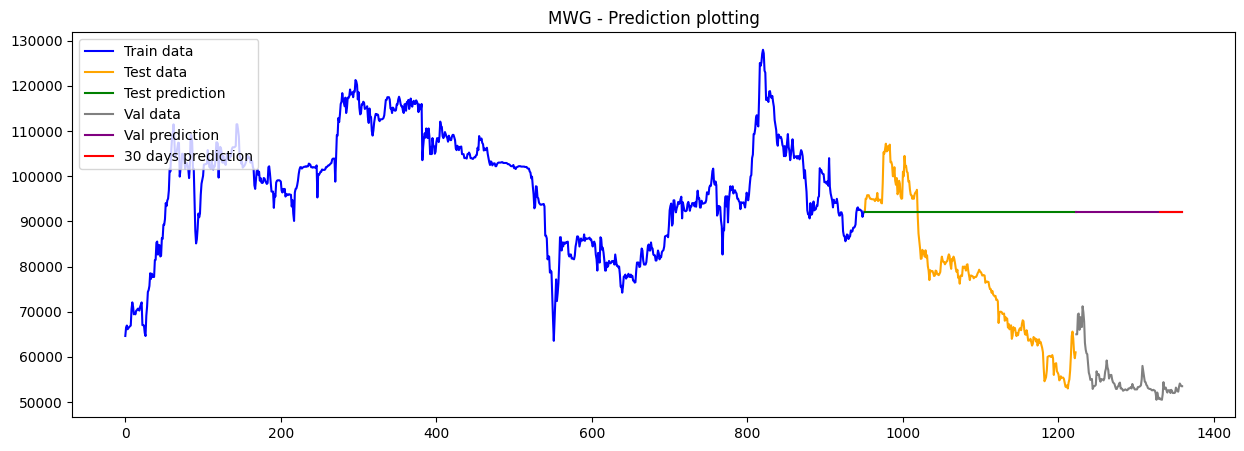

In [72]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data, c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, test_data, 'orange')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, val_data, 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df)-number_of_days_to_predict, stop=len(df), step=1)
plt.plot(prediect_data_index, y_next_N_days, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('MWG - Prediction plotting')
plt.show()